In [9]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [10]:
import os, sys
sys.path.append('../functions')

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [12]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


In [13]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=50, random_state=42)
#event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)

50


# Tracks Reconstruction

In [14]:
from baseline import SimpleTemplateMatching
from regressor import MultiLinearRegression
from reconstruction import TracksReconstruction2D
from combination import Combinator, SuperCombinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [15]:
event = data[data.EventID == 1251]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

labels = []
tracks_params = []

In [16]:
tracks = tracks_reconstruction(1251)

In [17]:
%%time
mlr = MultiLinearRegression(n_tracks=2, 
                            n_neighbors=20, 
                            min_samples=2, 
                            subsample=1, 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
mlr.fit(x, y)

labels = mlr.labels_
tracks_params = mlr.tracks_params_

CPU times: user 82.7 ms, sys: 549 µs, total: 83.3 ms
Wall time: 84.3 ms


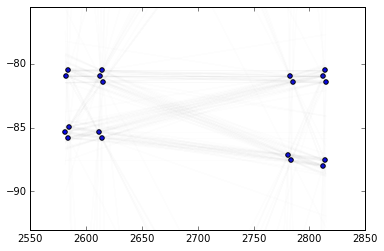

In [18]:
plt.scatter(x,y)
for slope, inter, err in zip(mlr.slopes_, mlr.intercepts_, mlr.stderrs_):
    plt.plot(x, x*slope+inter, color='0.5', alpha=0.01)
    
plt.ylim(y.min()-5, y.max()+5)
plt.show()

In [19]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [20]:
tracks_params

array([[ -1.94120216e-04,  -8.12033458e+01],
       [ -1.08752455e-02,  -5.71804795e+01]])

In [21]:
labels

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  0.])

In [22]:
event12.Label.values

array([ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.])

# Train Classifier for the Tracks Combination

In [23]:
%%time

from combination import SuperCombinator
from multiprocessing import Pool
from utils import merge_dicts

event_ids = event_ids_train
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = MultiLinearRegression(n_tracks=2, 
                            n_neighbors=20, 
                            min_samples=3, 
                            subsample=1, 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
    stm_stereo = MultiLinearRegression(n_tracks=1, 
                            n_neighbors=20, 
                            min_samples=3, 
                            subsample=1, 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
    #stm_stereo = SimpleTemplateMatching(n_max_hits=16, n_min_hits=6, window_width=5)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(4)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 91.2 ms, sys: 34.8 ms, total: 126 ms
Wall time: 3min 13s


In [24]:
sc = SuperCombinator()

combination_data = sc.data_collection(tracks, data)

X_data = combination_data[combination_data.columns[:-1]].values
y_data = combination_data.label.values

In [25]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=3, 
                             subsample=0.7, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 3.94 s, sys: 5.97 s, total: 9.91 s
Wall time: 7.04 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.7, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14'],
         n_folds=10, parallel_profile=None, random_state=11)

KFold prediction using folds column
KFold prediction using folds column
0.989528508772


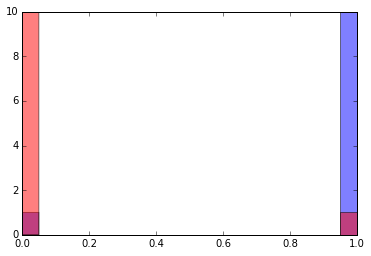

In [26]:
y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

y_proba = y_predict

from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data, y_proba)

plt.hist(y_proba[y_data==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba[y_data==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,10)
plt.show()

In [27]:
N = ((y_predict == y_data)*1).sum()
N_mis = ((y_predict != y_data)*1).sum()

print N, N_mis

189 2


### Tracks Reconstruction

In [28]:
%%time
from multiprocessing import Pool
from utils import merge_dicts
from regressor import MultiLinearRegression
import gc

event_ids = event_ids_test
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = MultiLinearRegression(n_tracks=2, 
                            n_neighbors=20, 
                            min_samples=3, 
                            subsample=1, 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
    stm_stereo = MultiLinearRegression(n_tracks=1, 
                            n_neighbors=20, 
                            min_samples=3, 
                            subsample=1, 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
    #stm_stereo = SimpleTemplateMatching(n_max_hits=16, n_min_hits=6, window_width=5)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    del tr2d12, tr2d34, stm_y, stm_stereo
    gc.collect()
    
    return one_track

if __name__ == "__main__":
    p = Pool(4)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

# results = []
# for event_id in event_ids:
#     one_result = tracks_reconstruction(event_id)
#     results.append(one_result)
# tracks = merge_dicts(results)

CPU times: user 627 ms, sys: 193 ms, total: 821 ms
Wall time: 11min 20s


In [29]:
# for i in event_ids:
#     print i
#     tracks_reconstruction(i)

In [30]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = SuperCombinator(classifier=folding.estimators[0])
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 24 s, sys: 748 ms, total: 24.7 s
Wall time: 24.9 s


# Quality

# Stations 1&2

### Y-views

In [31]:
tracks_metrics_before_y.mean(axis=0)

EventID      2559.479032
AvgEff          0.976797
RecoEff         0.981452
GhostRate       0.005645
CloneRate       0.004839
dtype: float64

### Stereo-views

In [32]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2559.479032
AvgEff          0.970983
RecoEff         0.969355
GhostRate       0.008065
CloneRate       0.001613
dtype: float64

### Stations 1&2

In [33]:
tracks_metrics_before_all.mean(axis=0)

EventID      2559.479032
AvgEff          0.972035
RecoEff         0.983065
GhostRate       0.005645
CloneRate       0.003226
dtype: float64

### Track efficiency

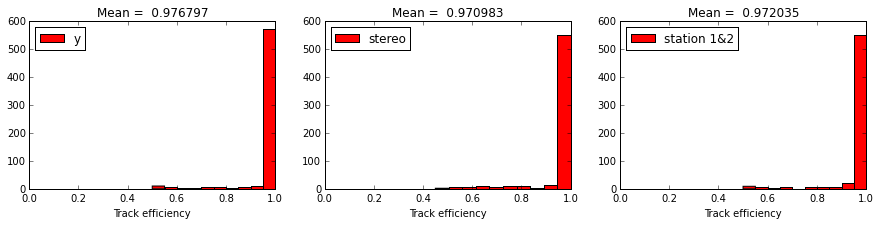

In [34]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

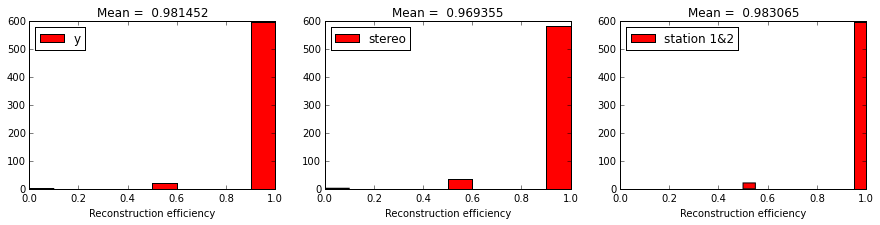

In [35]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [36]:
tracks_metrics_after_y.mean(axis=0)

EventID      2559.479032
AvgEff          0.981582
RecoEff         0.979032
GhostRate       0.014516
CloneRate       0.001613
dtype: float64

### Stereo-views

In [37]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2559.479032
AvgEff          0.973694
RecoEff         0.962097
GhostRate       0.016935
CloneRate       0.000000
dtype: float64

### Station 3&4

In [38]:
tracks_metrics_after_all.mean(axis=0)

EventID      2559.479032
AvgEff          0.976072
RecoEff         0.975806
GhostRate       0.012903
CloneRate       0.001613
dtype: float64

### Tracks efficiency

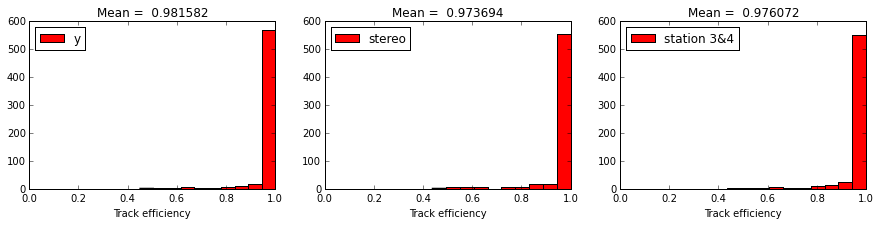

In [39]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

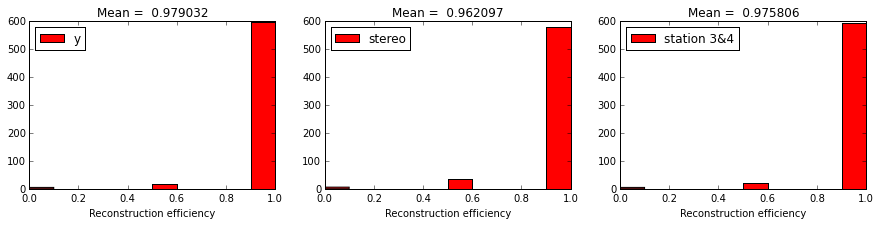

In [40]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [41]:
combinations_quality.mean(axis=0)

EventID      2559.479032
RecoEff         0.920968
GhostRate       0.009677
CloneRate       0.000000
NCombined       1.841935
dtype: float64

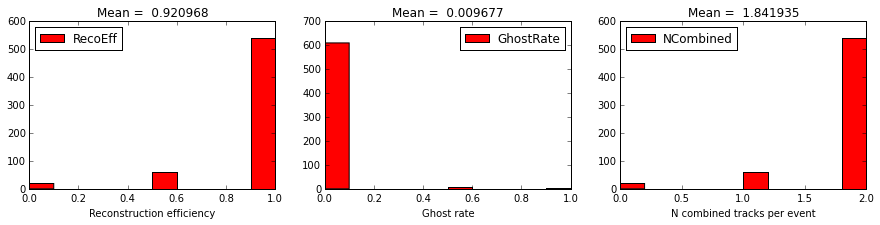

In [42]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

86.935483871


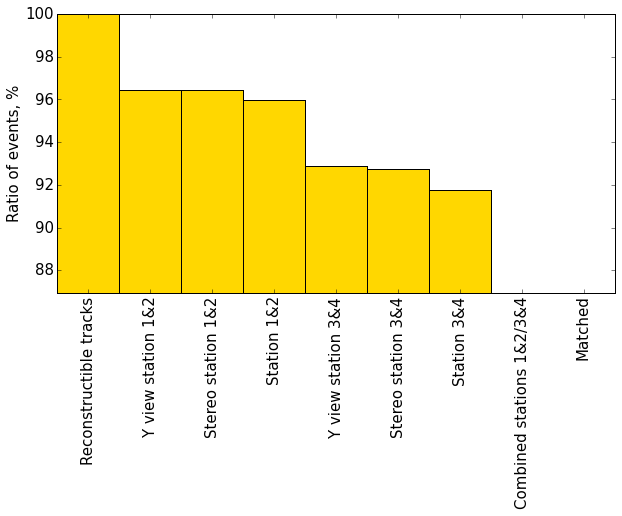

In [43]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [44]:
bar_values

array([ 100.        ,   96.4516129 ,   96.4516129 ,   95.96774194,
         92.90322581,   92.74193548,   91.77419355,   86.93548387,
         86.93548387])

# Momentum

In [45]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

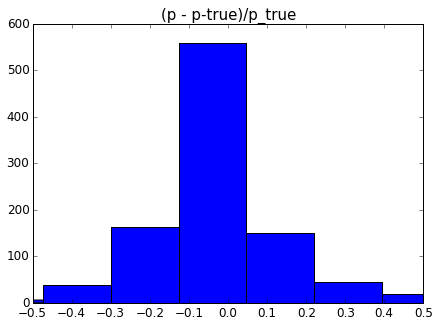

In [46]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=100, color='b')

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [47]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

12

In [48]:
print numpy.abs(p_err[numpy.isfinite(p_err)]).mean() * 100

15.6465140089


In [49]:
120*4.*60/570

50.526315789473685

# Did not recognized tracks

In [50]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
7,4108,1,0,0,0,0,0,0,0,0
15,3097,1,1,1,1,1,1,1,0,0
16,27,1,1,1,1,0,0,0,0,0
22,3110,1,0,0,0,0,0,0,0,0
23,39,1,1,1,1,1,1,1,0,0
33,4152,1,1,1,1,1,1,1,0,0
36,4156,1,0,0,0,0,0,0,0,0
40,1848,1,0,0,0,0,0,0,0,0
46,2232,1,0,0,0,0,0,0,0,0
51,3161,1,0,0,0,0,0,0,0,0


In [51]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

In [52]:
for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)

4108.0


NameError: name 'plot_event' is not defined